# imports

In [1]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from pandas import read_excel
import numpy as np
from numpy.linalg import eigh
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.pyplot.ion()
%matplotlib inline
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import (
    QUBO_to_Ising,
    find_offset,
    AnnealOffset,
    graph_summary,
)

from qlp.tdse import AnnealSchedule, TDSE, embed_qubo_example, convert_params

from qlpdb.tdse.models import Tdse

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw

# Setup

## Graph specific parameters 

Creates a line graph `o-o-o-...-o`

In [2]:
nvertices = 2
graph, tag = gt.generate_nn_graph(nvertices)
directed = False

## ILP / QUBO setup

Initializes the Qubo for the Minimum Dominating Set problem

In [3]:
penalty = 2
qubo = get_mds_qubo(
    graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
)
qubo_constant = penalty * nvertices

## Set up ising model

Computes the corresponding Ising model parameters for the QUBO

**if embed is True:** 
    This embeds the QUBO into a chimera graph. Currently there is only an explicit result from G(2). I will in the future actually embed with DWave minorminer.

In [4]:
Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())

embed = False  # nvertices = [2, 3] available
if embed:
    qubo, embedding = embed_qubo_example(nvertices)
    hi_for_offset = np.array(
        [
            hi[key]
            for key in np.sort(list(embedding.keys()))
            for count in range(len(embedding[key]))
        ]
    )
    Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
else:
    
    hi_for_offset = hi
    
n = len(qubo.todense())

graph_params = graph_summary(tag, graph, qubo)

## Anneal specific parameters

Parameters which are related to converting physical unites to unitless units

* **annealing_time:** Annealing time as defined from s = [0, 1] in microseconds
* **normalized_time:** This is s. Set it to < 0 or > 1 if offset is used to allow for a complete annealing schedule. The total time in microseconds will increase accordingly.
* **energyscale:** Converts units from D-Wave parameters to unitless parameters (see eq. 65 in the notes)

In [5]:
annealing_time = 0.0003
normalized_time = [-0.2, 1.2]  # make larger range for complete offsets

# assume annealing_time unit in microsecond and energy unit in Ghz
def energyscaleconversion(annealing_time):
    return annealing_time * 1000.0 * (2.0 * np.pi)

energyscale = energyscaleconversion(annealing_time)
ising_params = {"Jij": Jij, "hi": hi, "c": c, "energyscale": energyscale}

## Anneal curve specific parameters

Parameters which specify how the anneal curve is realized:

* **offset:** This is a string argument to the fcn method of the class AnnealOffset in qlp.mds.mds_qlpdb. Define your own anneal offset routine here or call
an existing one. E-mail me if you need more explanation.
* **offset_min, offset_range:** Argument to AnnealOffset class. Specify offset boundaries and are set later in a loop.
* **anneal_curve:** The realized curve. Currently implemented are linear, logistic and d-wave.
* **fill_value:** If normalized_time is extended beyond (0, 1), this option decides whether to extrapolate the anneal schedule, or truncate it at the nearest value.

In [6]:
offset = "negbinary"
anneal_curve = "linear"
fill_value = "truncate"

## Parameters for numerical solve of ODE

Parameters to solve the ODE. See also `scipy.integrate.solve_ivp`.

In [7]:
solver_params = dict()
solver_params["method"] = "RK45"
solver_params["rtol"] = 1e-6
solver_params["atol"] = 1e-7

## System parameters

Parameters used to specify the initial conditions of the system:

* **pure_tdse:** This is a boolean (True / False) flag and runs the pure state solver.
* **mixed_tdse:** This boolean flag runs the mixed state solver.
* **temp:** This sets the temperature for the mixed state solver in kelvins.
* **initial_wavefunction:** For the pure state solver, the initial wavefunc- tion can be chosen to be the ground state of ∑σx (transverse) or H(0)(real). For the DWave anneal schedule, or when annealing offsets are used without extended annealing times, these two options are not the same. Can be "true" or "transverse".


In [8]:
pure_tdse = False
mixed_tdse = True
temp = 1
initial_wavefunction = "true"

## Output parameters

Parameters used for visializing results:
* **degeneracy_tol:** This sets the numerical tolerance as to when an excited- state is labeled as degenerate to the ground state. This is important for graphs with degenerate ground states.
* **debug:** Write more output during computations.
* **save_result:** Store results to pickle files. 

In [9]:
degeneracy_tol = 2e-2
debug = False
save_result = False

# Run computations

In this section we run over different anneal time offsets

offset -0.0


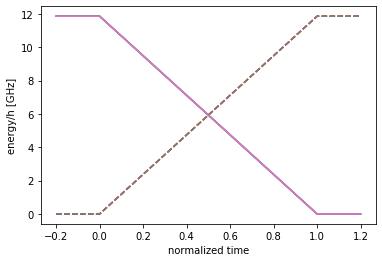

Final Prob: 0.7144131454817011
388 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
offset -0.05


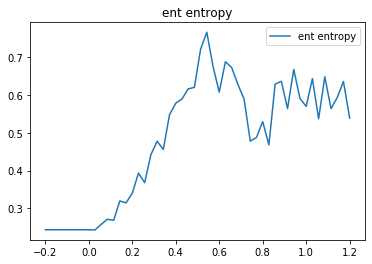

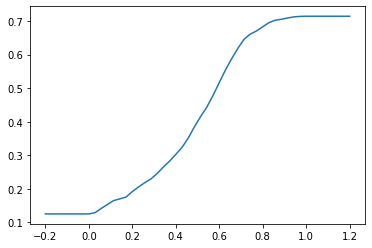

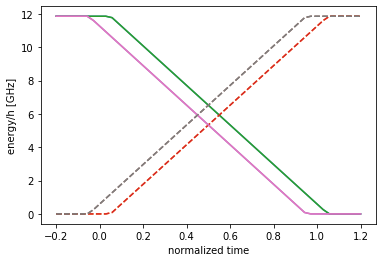

Final Prob: 0.7172725422232604
398 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


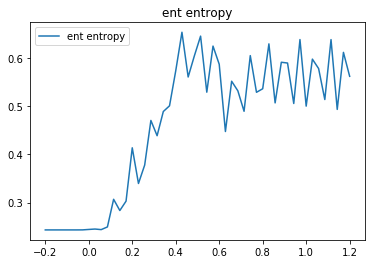

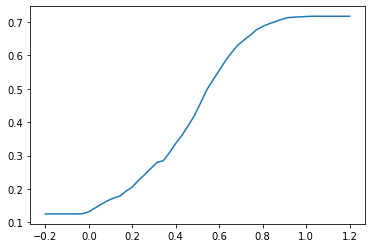

In [11]:
# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = -0.05 * np.arange(2)

for offset_min in offset_min_list:
    print("offset", offset_min)
    offset_min = offset_min
    offset_range = -2 * offset_min

    offset_params = {
        "annealing_time": annealing_time,
        "normalized_time": normalized_time,
        "offset": offset,
        "hi_for_offset": hi_for_offset,
        "offset_min": offset_min,
        "offset_range": offset_range,
        "fill_value": fill_value,
        "anneal_curve": anneal_curve,
    }

    # instantiate ode solver
    tdse = TDSE(n, ising_params, offset_params, solver_params)

    # plot anneal schedule
    tdse.AS.plot(normalized_time)

    # get offset list to get partition for entanglement entropy
    nA, indicesA = tdse.find_partition()
    reg = 1e-7
    
    ############################################################
    ###### code block for thermal mixed state simultation ######
    ############################################################
    if mixed_tdse:
        wave_params = dict()
        wave_params["type"] = "mixed"
        wave_params["temp"] = temp
        wave_params["initial_wavefunction"] = initial_wavefunction
        query = Tdse.objects.filter(
            graph__tag=graph_params["tag"],
            offset__contains=convert_params(offset_params),
            ising__contains=convert_params(ising_params),
            solver__contains=solver_params,
            wave__contains=wave_params,
            nA=nA,
            indicesA=indicesA,
        ).first()
        if not query:
            # initial density matrix
            rho = tdse.init_densitymatrix(temp, initial_wavefunction, debug=debug)

            # solve
            sol_densitymatrix = tdse.solve_mixed(rho)

            # calculate entanglement entropy
            # this example partion 4 qubits into A:(3,4) and B:(1,2)
            alls = np.asarray(
                [
                    tdse.ent_entropy(sol_densitymatrix.y[:, i], nA, indicesA, reg)
                    for i in range(sol_densitymatrix.t.size)
                ]
            ).real
            
            # overlap with Ising ground state
            gs_idx, Isingenergy, Isingeigv = tdse.ground_state_degeneracy(
                tdse.IsingH, degeneracy_tol, debug=debug
            )
            project = sum(
                [
                    np.kron(Isingeigv[:, idx], np.conj(Isingeigv[:, idx]))
                    for idx in gs_idx
                ]
            )
            prob = np.asarray(
                [
                    np.absolute((np.dot(np.conj(project), sol_densitymatrix.y[:, i])))
                    for i in range(sol_densitymatrix.t.size)
                ]
            )
            # save result to EspressoDB
            query = tdse.summary(
                graph_params=graph_params,
                penalty=penalty,
                ising_params=ising_params,
                offset_params=offset_params,
                solver_params=solver_params,
                wave_params=wave_params,
                instance=tdse,
                time=sol_densitymatrix.t,
                probability=prob,
                nA=nA,
                indicesA=indicesA,
                entropy=alls,
            )

        # plot entropy
        plt.figure()
        plt.plot(query.time, query.entropy)
        plt.legend(["ent entropy"])
        plt.title("ent entropy")

        # plot overlap with Ising g.s.
        plt.figure()
        plt.plot(query.time, query.prob)
        print(f"Final Prob: {query.prob[-1]}")

    ############################################################
    ###### end of code block for thermal mixed state simultation ######
    ############################################################

    if pure_tdse:
        # Initial wavefunction
        y1 = tdse.init_wavefunction(initial_wavefunction)

        # solve
        sol = tdse.solve_pure(y1, ngrid=2, debug=debug)

        # brute force diagonalization Ising hamiltonain
        ground_state_idx, energy, eigv = tdse.ground_state_degeneracy(
            tdse.IsingH, degeneracy_tol, debug=debug
        )

        # plot probability overlap with Ising ground state
        overlap = np.zeros(sol.t.size)
        overlap_annealH = np.zeros(sol.t.size)
        degen_number = np.zeros(sol.t.size)
        for i, t in enumerate(sol.t):
            # overlap with target Hamiltonian ground state
            overlap[i] = tdse.calculate_overlap(eigv, sol.y[:, i], ground_state_idx)
            # overlap with time-dependent Hamiltonian ground state
            annealH_gs_idx, eigval_annealH, eigv_annealH = tdse.ground_state_degeneracy(
                tdse.annealingH(t), degeneracy_tol
            )
            degen_number[i] = len(annealH_gs_idx)
            overlap_annealH[i] = tdse.calculate_overlap(
                eigv_annealH, sol.y[:, i], annealH_gs_idx
            )

        if save_result:
            with open(
                f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle",
                "wb",
            ) as file:
                rpickle = dict()
                rpickle["tdse"] = tdse
                rpickle["sol"] = sol
                rpickle["overlap"] = overlap
                rpickle["overlap_annealH"] = overlap_annealH
                rpickle["degen_number"] = degen_number
                pickle.dump(rpickle, file)
    """Runtime of code per loop"""
    %timeit -n 1 -r 1 pass


In [ ]:
result = dict()
proba = dict()
proba_annealH = dict()
degen_number = dict()

plt.figure("prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    with open(
        f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle",
        "rb",
    ) as file:
        rpickle = pickle.load(file)
        offset_range = -2 * offset_min
        result[offset_range] = rpickle["tdse"]
        proba[offset_range] = rpickle["overlap"][-1]
        proba_annealH[offset_range] = rpickle["overlap_annealH"][-1]
        degen_number[offset_range] = rpickle["degen_number"]
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap"], label=offset_range)

ax.legend()
ax.set_xlabel("time s")
ax.set_ylabel(r"$P= |<\psi (s) | gnd >|^2$")
plt.title("Probability of reaching Ising ground state")
plt.savefig("./proba.pdf")
plt.show()

plt.figure("annealH prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap_annealH"], label=offset_range)
ax.legend()
ax.set_xlabel("time s")
ax.set_ylabel(r"$P= |<\psi (s) | \psi_0(s) >|^2$")
plt.title("Probability of wavefunction in H(s) ground-state")
plt.show()

plt.figure("degeneracy number")
ax = plt.axes()
for offset_min in offset_min_list:
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["degen_number"], label=offset_range)
ax.legend()
ax.set_xlabel("time s")
ax.set_ylabel(r"ground-state degeneracy")
plt.show()

plt.figure("prob final")
ax = plt.axes()
ax.errorbar(x=list(proba.keys()), y=list(proba.values()), marker="o")
ax.set_xlabel("offset range")
ax.set_ylabel("s=1 probability")
plt.title(offset)
plt.show()

# plot last anneal schedule
plt.figure()
ax = plt.axes()
X = np.linspace(*normalized_time)
yA = np.array([tdse.AS.A(Xi) for Xi in X])
yB = np.array([tdse.AS.B(Xi) for Xi in X])
for qubit in range(len(yA[0])):
    ax.errorbar(x=X, y=yA[:, qubit])
    ax.errorbar(x=X, y=yB[:, qubit], ls="--")

In [ ]:
# unit conversion
# sol.y = [GHz / h]
make_dimensionless = 1 / energyscale * 1 / tdse.AS.B(normalized_time[1])[0]

tdse = TDSE(n, ising_params, offset_params, solver_params)

fig = plt.figure()
ax = plt.axes()
num_es = 10
gap = dict()
for key in result.keys():
    x = []
    y = {es: [] for es in range(num_es)}
    for s in np.linspace(normalized_time[0], normalized_time[1]):
        eigval, eigvec = eigh(result[key].annealingH(s))
        seigval = (
            np.sort(eigval) * make_dimensionless + ising_params["c"] + qubo_constant
        )
        x.append(s)
        for es in y.keys():
            y[es].append(seigval[es])
    for es in y.keys():
        ax.errorbar(x=x, y=y[es])
    gap[key] = {es: np.array(y[es]) - np.array(y[0]) for es in y.keys()}
plt.draw()
plt.show()
print("ground state energy:", y[0][-1])
print("1st ex state energy:", y[1][-1])
eigval, eigvec = eigh(result[key].annealingH(s))
print("ground state eigvec:", np.round(eigvec[0]))
print("1st ex state eigvec:", np.round(eigvec[1]))

In [ ]:
fig = plt.figure()
ax = plt.axes()
for key in gap.keys():
    for es in gap[key].keys():
        ax.errorbar(x=x, y=gap[key][es], label=es)
# ax.legend()
plt.draw()
plt.show()
# print(f"e1-e0 gap[offset_range={min(gap.keys())}][{sum(mask)}]:", gap[min(gap.keys())][sum(mask)][-1])
# print(f"e2-e0 gap[offset_range={min(gap.keys())}][{sum(mask)+1}]:", gap[min(gap.keys())][sum(mask)+1][-1])

In [ ]:
mingap = {key: min(gap[key][1]) for key in gap.keys()}
plt.figure()
ax = plt.axes()
x = list(mingap.keys())
y = list(mingap.values())
ax.errorbar(x=x, y=y, marker="o")
plt.draw()
plt.show()
mingap

In [ ]:
import pickle

In [ ]:
ptdse = pickle.dumps(tdse)

In [ ]:
rtdse = pickle.loads(ptdse)

In [ ]:
rtdse.AS